In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#### Details of methodology

The dataset is passed to the dataloader as an array of filepaths. The labels are simply strings mapped to corresponding values.

run_fitting.py: 
```
LABELS = {
            'neutral': 0,
            'provocative': 1,
            'nsfw': 2
            }
```

In order to reduce the amount of data loaded into memory at a time, we allow the DataSet object to load images whenever the DataLoader calls them. This decreases the speed for each batch in SGD (as images need to be loaded into memory on each batch), however it also decreases the total memory used at any given time. If this project were to be run on a more powerful machine, it would otherwise be best load the imageset eagerly.

Infrastructure.py:
```
def __getitem__(self, index:int) -> Tuple[torch.Tensor, str]:
        img = Image.open(self.X[index]).convert('RGB')
        return self.transform(img), self.y[index]
```

We then also split the data into Training, Test and Validation. "Validation" confirms the dataset accuracy at the end of fitting. The "Test" dataset is used to approximate loss at each epoch interval. Its size is intentionally made small since we need only to quickly calculate loss in order to tune the number of epochs. To this end, the model weights are only saved when validation at current epoch < minimum validation so far.

run_fitting.py:
```
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = TEST_SIZE )
X_test, X_val, y_test, y_val = train_test_split(X,y, test_size = 0.3)
```

We chose to use simple Cross Entropy Loss and the Adam optimizer to train a single classification per image and make use of our "smaller" dataset. The dataset is quite noisy, meaning that many images are generally misclassified. For this reason, we employ as large of a dataset as possible and restrict the learning rate to a conservative 1e-3. We will instead run the model for a larger number of epochs to mitigate this effect. We also choose to stratify the dataset per batch. This does bias images with fewer samples (namely the NSFW images), however this allows for more balanced loss calculations per epoch. Lastly, we apply several transformations to each image to ensure that the image reading is random. This is wrapped in the compose function for each image loaded.

Infrastructure.py:
```
T.Compose([
        T.RandomRotation(30),
        T.RandomResizedCrop(224),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
```

The neural net is then run, with intermittent evaluation of the cumulative training and validation loss to determine the stopping point for the training process.

In [2]:
trends = pd.read_csv('./Scoring.txt')

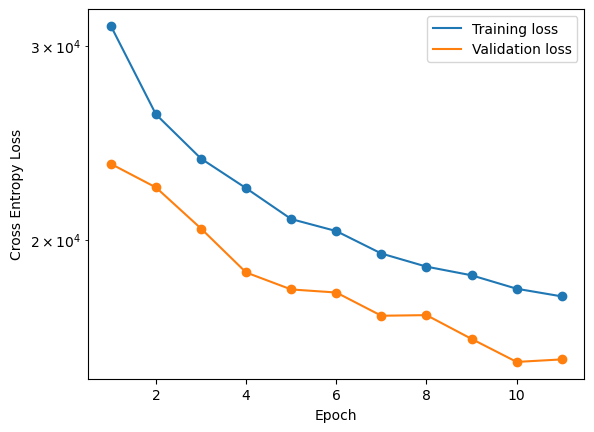

In [3]:
fig, ax = plt.subplots()

ax.plot(trends['Epoch'], trends[' Train Loss'], label = 'Training loss')
ax.plot(trends['Epoch'], trends[' Val Loss'], label = 'Validation loss')
ax.scatter(trends['Epoch'], trends[' Train Loss'], marker='o', zorder = 1)
ax.scatter(trends['Epoch'], trends[' Val Loss'], marker='o', zorder = 1)

ax.set_yscale('log')

ax.set_xlabel('Epoch')
ax.set_ylabel('Cross Entropy Loss')
ax.legend()

fig.savefig('ModelFitting.png')

As is evident, the training loss continues decreasing whereas the validation loss reaches a minimum and begins to climb again. The fitting process is halted and the model state reverted to that of the minimum validation loss. At this point, the model is fitted and we can begin testing the model's performance.

Following our business objective, we develop three criteria. One has already been seen -- raw accuracy encapsulates the ability for the model to differentiate NSFW images. Second, we want to calculate the false-negative rate. Missing out on images that should otherwise be classified as NSFW could be damaging to the business' reputation. Lastly, we want to calculate the false-positive rate. We want to understand how often customers' images are incorrectly flagged as NSFW, as this has ramifications for either frustration for the customer or increased man-hours to remediate the situation.
To this end, it is easiest to build a confusion matrix, and calculate the respective rates from there.

As per our business objective, our main criteria is to accurately tag "NSFW" and "provocative" images. Of course, we build two separate criteria as these classes can often look quite different. Nonetheless, we evaluate accuracy on the basis of accurately predicting a binary class in  which NSFW: ['nsfw', 'provocative'] and Non-NSFW: 'neutral' only.

In the subsequent section, I transferred a random subset of the images in the validation set to a separate directory. It should be noted that, across the entire validation set, the accuracy score is 85%. However, in subsetting the validation set, the accuracy is expected to change significantly as the noise in the dataset is still present.



In [4]:
import torch
from torch.utils.data import DataLoader
from Infrastructure import CaptchaDataset, ResNetWrapper
from pathlib import Path
from sklearn.model_selection import train_test_split

import logging
logging.basicConfig(level=logging.ERROR)

import numpy as np

In [31]:
LABELS = {
            'neutral': 0,
            'provocative': 1,
            'nsfw': 2
            }


DATA_DIR = './test_images/'

directories = {
            'neutral': '%s/neutral/'%DATA_DIR,
            'provocative': '%s/provocative/'%DATA_DIR,
            'nsfw': '%s/nsfw/'%DATA_DIR,
            }


for label in directories:

    # Collect the files
    file_locations = [ img for img in Path(directories[label]).glob('*') ]

    # Just reassign directories vals to the glob
    directories[label] = file_locations


X = []
for label in directories:
    X+= directories[label]
y = []
for label in directories:
    y+= [LABELS[label]] * len(directories[label])

# I accidentally forgot to rename this CaptchaDataset class & it's too late now -> "tech debt"
dataloader = DataLoader(CaptchaDataset(X,y), 
    64, shuffle=True, num_workers = 4)

net = ResNetWrapper()
statedict = torch.load('./ResNetWrapper_weights.pth', map_location = torch.device('cpu'))
# Honestly not sure why saving from outside wrapper changes the odict names
net.load_state_dict( { 'network.%s'%key : statedict[key] for key in statedict } 
    )


cm = net.validate(dataloader, confusion_matrix = True)

[Text(0.5, 1.0, 'Confusion Matrix')]

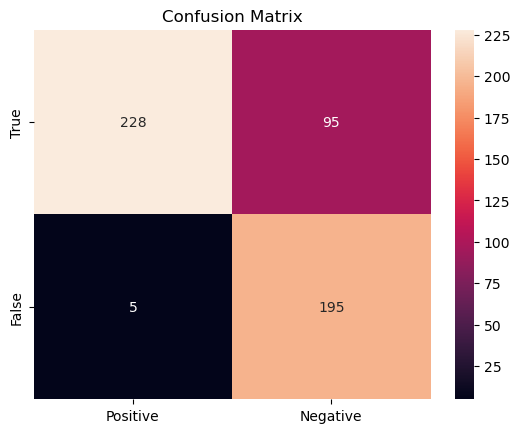

In [36]:
import seaborn as sns

data = np.array(list(cm.values())).reshape(2,2)

sns.heatmap(
    pd.DataFrame(data, index = [ 'True', 'False' ] , columns = [ 'Positive', 'Negative' ] ), annot = True, fmt = '.0f', 
).set(title = 'Confusion Matrix')

Our model performs on the test data with a total accuracy of 80%. The false-negative rate is roughly 30% -- not a great score. In comparison, the false-positive rate is less than 2.5%. Clearly, this reflects the much larger "neutral" dataset, which allows for more variability in the dataset.

Following these results, we can make some conclusions on improvements for the future.

First, a larger dataset would definitely improve results -- especially a more even distribution of photos among the classes. I tried to rectify this issue with stratification and a image transformations, but clearly the model was not able to improve its false-negative rate sufficiently. This false-negative rate is one of our main deliverables, so it should be prioritized.

To this end: with more time, I would have experimented with penalizing false negatives by optimizing for recall. This could be a post-train tuning of the model, to avoid lowering precision unnecessarily.

All-in-all, however we can assess the value of adding this feature to our model as it is. Assessing on the basis of the accuracy, we can predict a reduction of >20% human involvement with content moderation. The relatively few false positive reduce the need for humans to remediate incorrectly-flagged content. Due to the high false-negative rate, however, we would still require human moderation.